In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [2]:
# import the excel data from the data subfolder that starts 
ca_ = pd.read_excel('data/21in05ca.xlsx', header=3)[3:5]
fl_ = pd.read_excel('data/21in10fl.xlsx', header=3)[3:5]
hi_ = pd.read_excel('data/21in12hi.xlsx', header=3)[3:5]
mn_ = pd.read_excel('data/21in24mn.xlsx', header=3)[3:5]
nv_ = pd.read_excel('data/21in29nv.xlsx', header=3)[3:5]
nj_ = pd.read_excel('data/21in31nj.xlsx', header=3)[3:5]
or_ = pd.read_excel('data/21in38or.xlsx', header=3)[3:5]
tn_ = pd.read_excel('data/21in43tn.xlsx', header=3)[3:5]
tx_ = pd.read_excel('data/21in44tx.xlsx', header=3)[3:5]
wa_ = pd.read_excel('data/21in48wa.xlsx', header=3)[3:5]

In [3]:
# clean the dataframes
list_df = [ca_, fl_, hi_, mn_, nv_, nj_, or_, tn_, tx_, wa_]
group_t = ['California', 'Hawaii', 'Minnesota', 'New Jersey', 'Oregon']
for df in list_df:
    # sum the returns in the columns
    df['State'] = df.iloc[0,0]
    df['State'] = df['State'].str.title()
    df.drop(index=3, inplace=True)
    df['Total Returns'] = df.iloc[:,2:12].sum(axis=1)
    if (df.iloc[:,1] != df['Total Returns']).all() != 0:
        print(f"error in {df['State'].item()}, discrepancy of {(df.iloc[:,1] - df['Total Returns']).item():.0f} using the calculated total")
    df.drop(columns=df.columns[1:11], inplace=True)
    df.rename(columns={'$1,000,000\nor\nmore': 'High Income Returns', 'Unnamed: 0': 'Series Name'}, inplace=True)
    df['High Income Share'] = df['High Income Returns'] / df['Total Returns']
    df['High Income Share (%)'] = df['High Income Share']*100
    if df['State'].item() in group_t:
        df['Group T'] = True
    else:
        df['Group T'] = False

error in California, discrepancy of -10 using the calculated total
error in Hawaii, discrepancy of -10 using the calculated total
error in Minnesota, discrepancy of 10 using the calculated total
error in Oregon, discrepancy of -10 using the calculated total
error in Tennessee, discrepancy of -10 using the calculated total


In [4]:
# concatenate the dataframes
df = pd.concat(list_df)

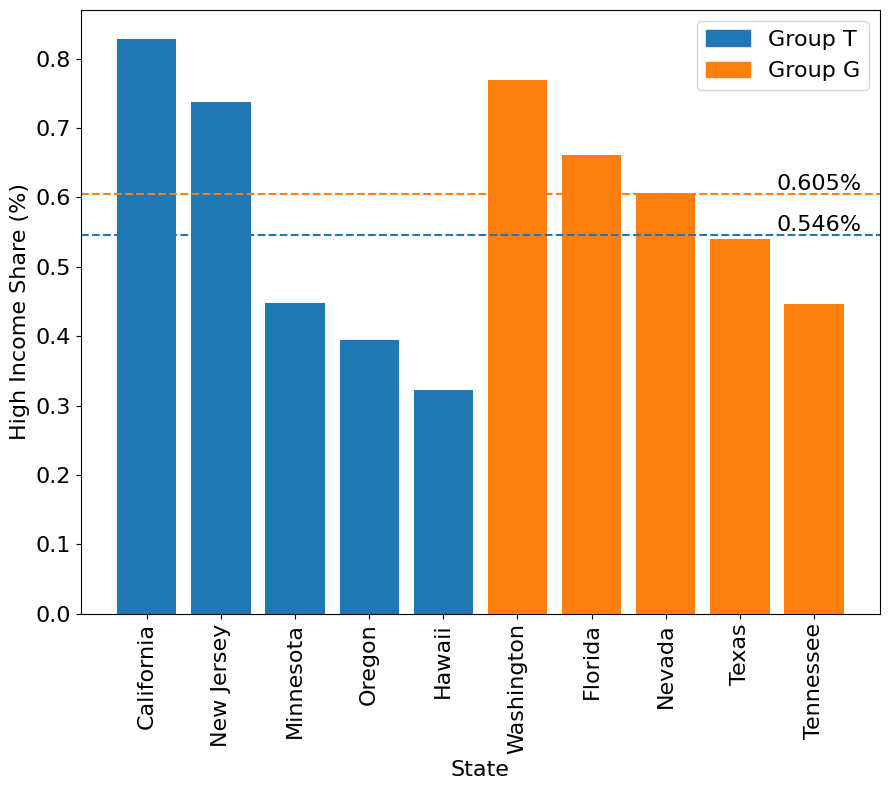

In [13]:
# prepare the data for plotting
df.sort_values(['Group T','High Income Share'], ascending=[False,False], inplace=True)
colors = df['Group T'].map({True: 'tab:blue', False: 'tab:orange'})
group_t_avg = df[df['Group T']]['High Income Share (%)'].mean()
group_g_avg = df[~df['Group T']]['High Income Share (%)'].mean()

# plot the data
plt.figure(figsize=(9,8))
plt.bar(df['State'], df['High Income Share (%)'], color=colors)
plt.axhline(y=group_t_avg, color='tab:blue', linestyle='--')
plt.axhline(y=group_g_avg, color='tab:orange', linestyle='--')

# add the average as text to the plot
plt.text(8.5, group_t_avg, f'{group_t_avg:.3f}%', verticalalignment='bottom', fontsize=16)
plt.text(8.5, group_g_avg, f'{group_g_avg:.3f}%', verticalalignment='bottom', fontsize=16)

plt.ylabel('High Income Share (%)', fontsize=16)
plt.xlabel('State', fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16, rotation=90)
group_t_patch = mpatches.Patch(color='tab:blue', label='Group T')
group_g_patch = mpatches.Patch(color='tab:orange', label='Group G')
plt.legend(handles=[group_t_patch, group_g_patch], fontsize=16)
plt.tight_layout()
plt.savefig('high_income_share_by_state.png')
plt.show()
